In [3]:
# @title SaaS Churn Prediction and Revenue Optimization Project
# @markdown Complete project for predicting customer churn in SaaS companies

# Step 1: Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost shap plotly fpdf joblib

# Step 2: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from fpdf import FPDF
import joblib
import io
from google.colab import files

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("All packages installed and imported successfully!")

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=a81e3ae67ab877d52ae4f4919698c2bd627ab452587d20a79095e7de75498a26
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf
All packages installed and imported successfully!


In [4]:
# Step 3: Generate synthetic SaaS data
print("Generating synthetic SaaS customer data...")

def generate_saas_data(num_customers=5000):
    np.random.seed(42)
    random.seed(42)

    # Base data structure
    data = {
        'customer_id': [f'CUST_{i:04d}' for i in range(num_customers)],
        'signup_date': [datetime(2022, 1, 1) + timedelta(days=random.randint(0, 730))
                       for _ in range(num_customers)],
        'subscription_plan': np.random.choice(['Basic', 'Pro', 'Enterprise'],
                                             size=num_customers, p=[0.6, 0.3, 0.1]),
        'monthly_revenue': np.zeros(num_customers),
        'tenure_days': np.zeros(num_customers),
        'login_count_30d': np.zeros(num_customers),
        'feature_A_usage': np.zeros(num_customers),
        'feature_B_usage': np.zeros(num_customers),
        'support_tickets': np.zeros(num_customers),
        'last_support_response_hrs': np.zeros(num_customers),
        'days_since_last_login': np.zeros(num_customers),
        'payment_method': np.random.choice(['Credit Card', 'PayPal', 'Bank Transfer'],
                                         size=num_customers, p=[0.7, 0.2, 0.1]),
        'failed_payments_6m': np.zeros(num_customers),
        'churn': np.zeros(num_customers)
    }

    df = pd.DataFrame(data)

    # Set revenue based on plan
    df.loc[df.subscription_plan == 'Basic', 'monthly_revenue'] = np.random.normal(50, 5,
                                                                   len(df[df.subscription_plan == 'Basic']))
    df.loc[df.subscription_plan == 'Pro', 'monthly_revenue'] = np.random.normal(100, 10,
                                                                len(df[df.subscription_plan == 'Pro']))
    df.loc[df.subscription_plan == 'Enterprise', 'monthly_revenue'] = np.random.normal(250, 25,
                                                                     len(df[df.subscription_plan == 'Enterprise']))

    # Calculate tenure
    max_date = datetime(2023, 12, 31)
    df['tenure_days'] = (max_date - df['signup_date']).dt.days

    # Generate behavioral data with realistic patterns
    for i in range(num_customers):
        plan = df.loc[i, 'subscription_plan']

        # Higher plans have more logins and feature usage
        if plan == 'Basic':
            df.loc[i, 'login_count_30d'] = max(0, np.random.normal(8, 5))
            df.loc[i, 'feature_A_usage'] = max(0, np.random.normal(5, 3))
            df.loc[i, 'feature_B_usage'] = max(0, np.random.normal(2, 2))
        elif plan == 'Pro':
            df.loc[i, 'login_count_30d'] = max(0, np.random.normal(15, 6))
            df.loc[i, 'feature_A_usage'] = max(0, np.random.normal(12, 4))
            df.loc[i, 'feature_B_usage'] = max(0, np.random.normal(8, 3))
        else:  # Enterprise
            df.loc[i, 'login_count_30d'] = max(0, np.random.normal(25, 8))
            df.loc[i, 'feature_A_usage'] = max(0, np.random.normal(20, 5))
            df.loc[i, 'feature_B_usage'] = max(0, np.random.normal(15, 4))

        # Support tickets - some users have more issues
        df.loc[i, 'support_tickets'] = np.random.poisson(0.7) if random.random() > 0.2 else np.random.poisson(3)

        # Response time - sometimes slow
        df.loc[i, 'last_support_response_hrs'] = np.random.exponential(8) if random.random() > 0.1 else np.random.exponential(48)

        # Days since last login - some are inactive
        df.loc[i, 'days_since_last_login'] = np.random.exponential(3) if random.random() > 0.15 else np.random.exponential(30)

        # Failed payments
        df.loc[i, 'failed_payments_6m'] = np.random.poisson(0.2) if random.random() > 0.05 else np.random.poisson(3)

    # Create churn flags based on realistic patterns
    for i in range(num_customers):
        churn_prob = 0.05  # base churn probability

        # Risk factors
        if df.loc[i, 'days_since_last_login'] > 14:
            churn_prob += 0.3
        if df.loc[i, 'failed_payments_6m'] >= 2:
            churn_prob += 0.4
        if df.loc[i, 'last_support_response_hrs'] > 24:
            churn_prob += 0.2
        if df.loc[i, 'support_tickets'] > 3 and df.loc[i, 'last_support_response_hrs'] > 12:
            churn_prob += 0.25
        if df.loc[i, 'login_count_30d'] < 5:
            churn_prob += 0.15

        # Protection factors
        if df.loc[i, 'subscription_plan'] == 'Enterprise':
            churn_prob -= 0.1
        if df.loc[i, 'feature_A_usage'] > 10 or df.loc[i, 'feature_B_usage'] > 8:
            churn_prob -= 0.15

        # Ensure probability is between 0 and 1
        churn_prob = max(0.01, min(0.99, churn_prob))

        # Determine churn
        df.loc[i, 'churn'] = 1 if random.random() < churn_prob else 0

    # Drop date column for modeling
    df = df.drop('signup_date', axis=1)

    return df

# Generate the data
saas_data = generate_saas_data(5000)

# Display basic info
print(f"Dataset shape: {saas_data.shape}")
print(f"Churn rate: {saas_data.churn.mean():.2%}")

# Show first few rows
saas_data.head()

Generating synthetic SaaS customer data...
Dataset shape: (5000, 13)
Churn rate: 12.60%


,customer_id,subscription_plan,monthly_revenue,tenure_days,login_count_30d,feature_A_usage,feature_B_usage,support_tickets,last_support_response_hrs,days_since_last_login,payment_method,failed_payments_6m,churn
0,CUST_0000,Basic,42.560691,75,4.740239,4.699916,4.960366,0.0,4.361027,0.277275,Credit Card,0.0,0.0
1,CUST_0001,Enterprise,211.481055,615,29.070107,19.678448,10.149038,2.0,7.327686,2.242801,Credit Card,0.0,0.0
2,CUST_0002,Pro,96.256100,704,13.328492,13.412157,8.292252,0.0,0.851830,0.868547,PayPal,0.0,0.0
3,CUST_0003,Basic,44.374069,448,6.701566,1.593208,2.810480,0.0,31.617519,1.844325,Credit Card,1.0,0.0
4,CUST_0004,Basic,51.944095,479,8.527196,6.740958,1.353126,0.0,16.917334,6.788204,PayPal,0.0,0.0


Performing exploratory data analysis...
COMPREHENSIVE EXPLORATORY DATA ANALYSIS

1. DATABASE OVERVIEW
Shape: (5000, 13)
Memory usage: 1.20 MB

2. DATA QUALITY CHECK
Missing values:
customer_id                  0
subscription_plan            0
monthly_revenue              0
tenure_days                  0
login_count_30d              0
feature_A_usage              0
feature_B_usage              0
support_tickets              0
last_support_response_hrs    0
days_since_last_login        0
payment_method               0
failed_payments_6m           0
churn                        0
dtype: int64

3. TARGET VARIABLE ANALYSIS
Overall churn rate: 12.60%

4. NUMERICAL FEATURES SUMMARY
       monthly_revenue  tenure_days  login_count_30d  feature_A_usage  \
count      5000.000000  5000.000000      5000.000000      5000.000000   
mean         84.338095   359.143000        11.802162         8.652341   
std          59.150393   210.981854         7.559253         6.041630   
min          30.387999  

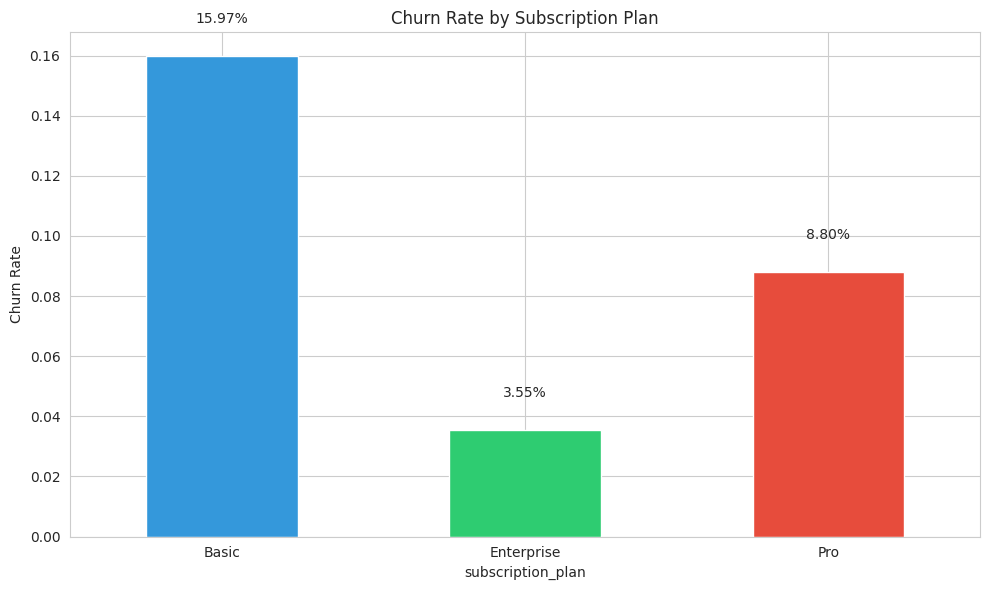

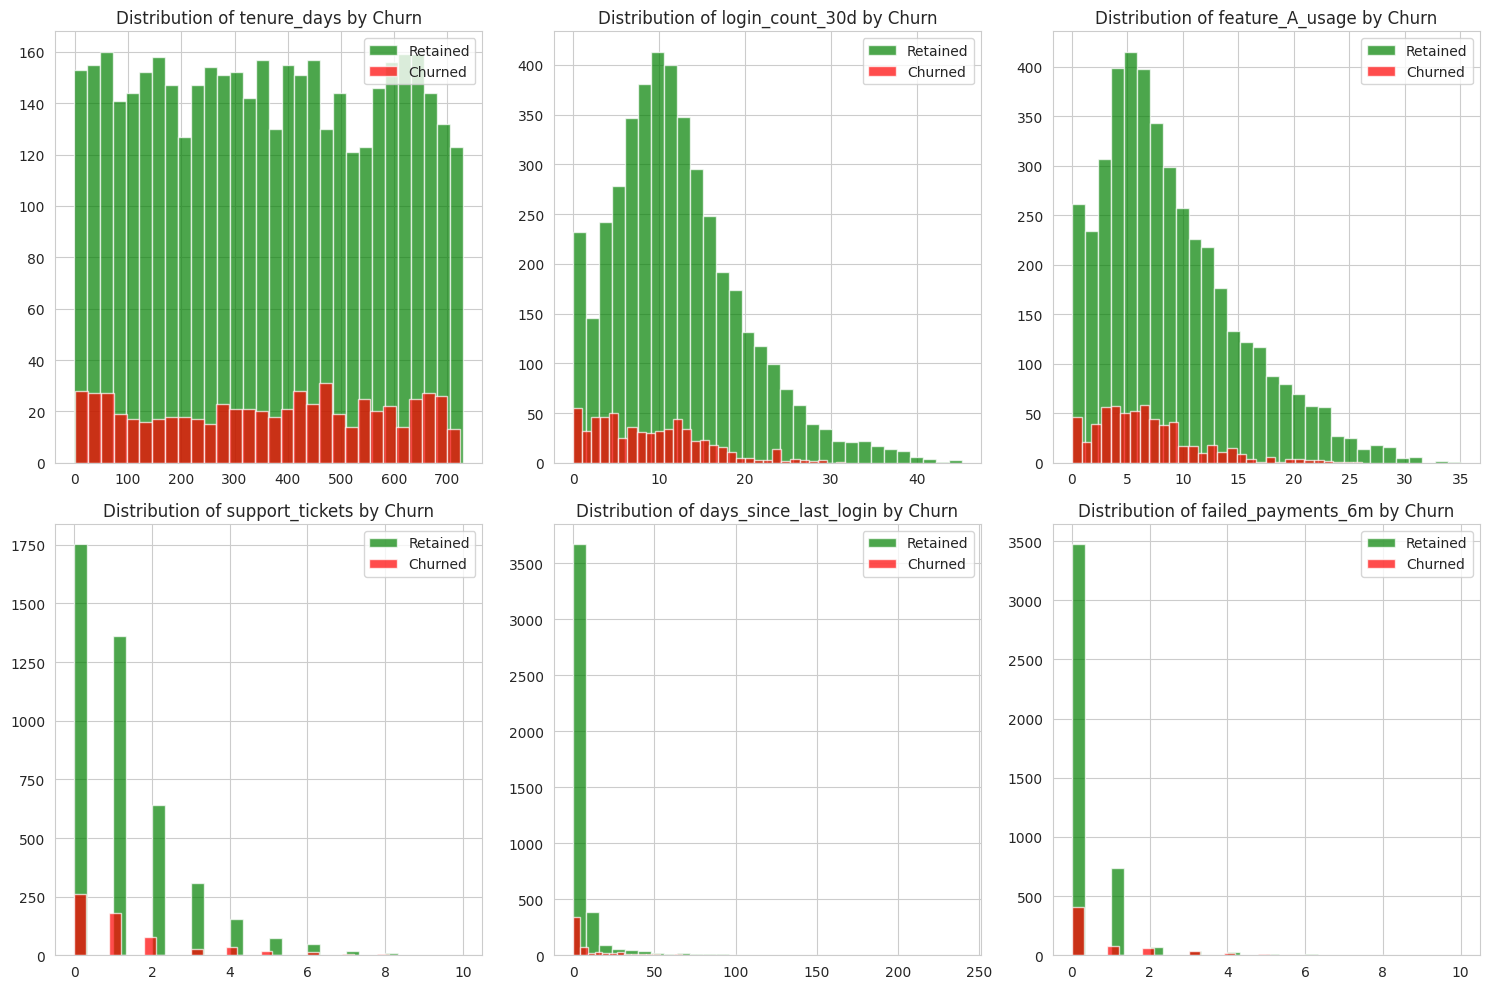

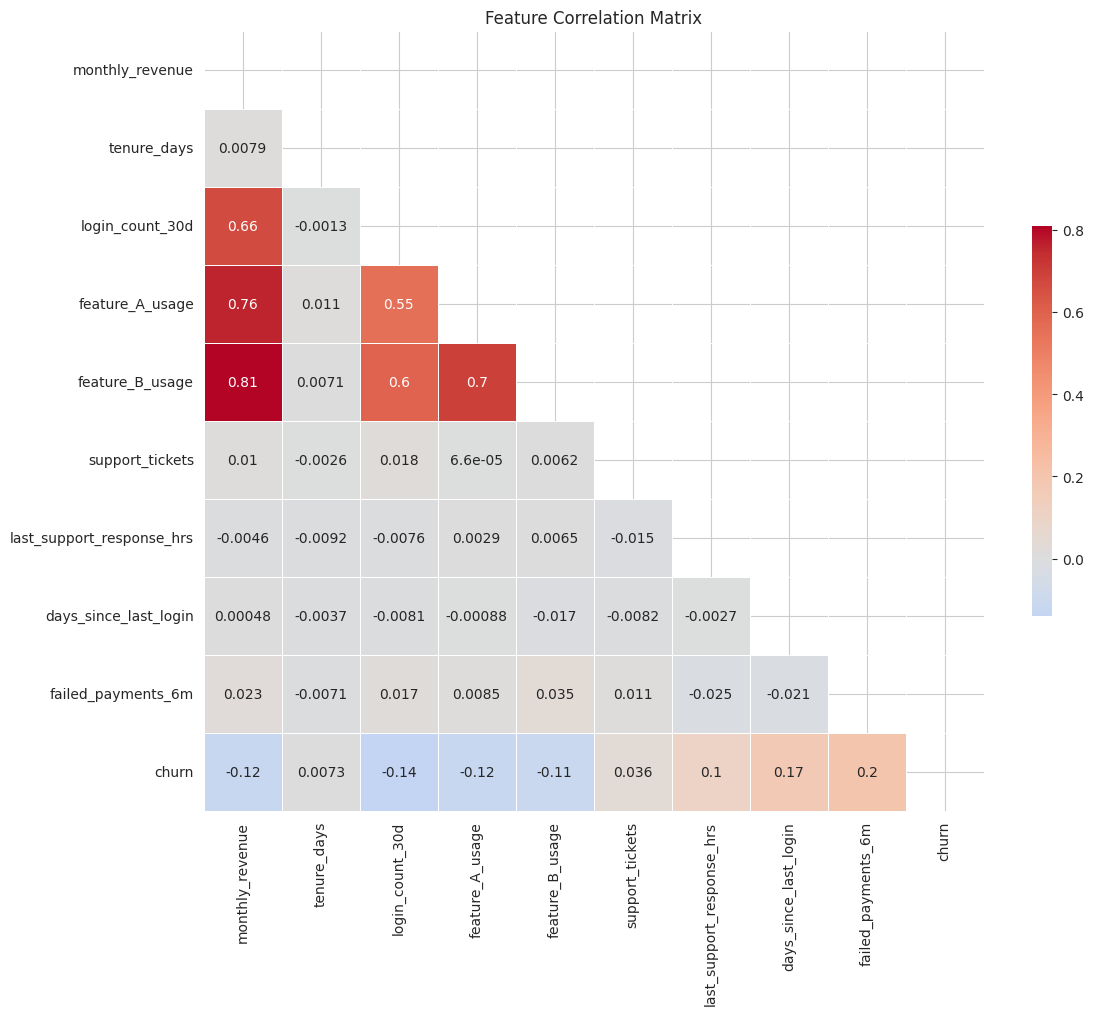


7. STATISTICAL SIGNIFICANCE TESTING

T-test results (churned vs retained):
monthly_revenue: t-stat = -11.825, p-value = 0.0000
tenure_days: t-stat = 0.512, p-value = 0.6085
login_count_30d: t-stat = -11.244, p-value = 0.0000
feature_A_usage: t-stat = -10.262, p-value = 0.0000
feature_B_usage: t-stat = -9.706, p-value = 0.0000
support_tickets: t-stat = 2.176, p-value = 0.0299
last_support_response_hrs: t-stat = 5.873, p-value = 0.0000
days_since_last_login: t-stat = 8.671, p-value = 0.0000
failed_payments_6m: t-stat = 9.016, p-value = 0.0000

Chi-square test results:
customer_id: chi2 = 5000.000, p-value = 0.4934
subscription_plan: chi2 = 86.510, p-value = 0.0000
payment_method: chi2 = 0.313, p-value = 0.8553

8. CUSTOMER LIFETIME VALUE ANALYSIS
Average CLV for churned customers: $803.34
Average CLV for retained customers: $1043.16
Value at risk: $506105.60


In [5]:
# Step 4: Exploratory Data Analysis (EDA)
print("Performing exploratory data analysis...")

def comprehensive_eda(df):
    print("=" * 50)
    print("COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("=" * 50)

    # 1. Basic information
    print("\n1. DATABASE OVERVIEW")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

    print("\n2. DATA QUALITY CHECK")
    print("Missing values:")
    print(df.isnull().sum())

    print("\n3. TARGET VARIABLE ANALYSIS")
    churn_rate = df.churn.mean()
    print(f"Overall churn rate: {churn_rate:.2%}")

    # 4. Numerical features analysis
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features.remove('churn')  # Remove target

    print("\n4. NUMERICAL FEATURES SUMMARY")
    print(df[numerical_features].describe())

    # 5. Categorical features analysis
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    print("\n5. CATEGORICAL FEATURES DISTRIBUTION")
    for feature in categorical_features:
        print(f"\n{feature}:")
        print(df[feature].value_counts())

    # 6. Visualizations
    print("\n6. GENERATING VISUALIZATIONS...")

    # Churn by subscription plan
    plt.figure(figsize=(10, 6))
    churn_by_plan = df.groupby('subscription_plan')['churn'].mean()
    ax = churn_by_plan.plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Churn Rate by Subscription Plan')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=0)

    # Add value labels on bars
    for i, v in enumerate(churn_by_plan):
        ax.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Distribution of numerical features by churn
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    features_to_plot = ['tenure_days', 'login_count_30d', 'feature_A_usage',
                       'support_tickets', 'days_since_last_login', 'failed_payments_6m']

    for i, feature in enumerate(features_to_plot):
        df[df.churn == 0][feature].hist(alpha=0.7, bins=30, ax=axes[i], label='Retained', color='green')
        df[df.churn == 1][feature].hist(alpha=0.7, bins=30, ax=axes[i], label='Churned', color='red')
        axes[i].set_title(f'Distribution of {feature} by Churn')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()

    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # 7. Statistical tests
    print("\n7. STATISTICAL SIGNIFICANCE TESTING")

    # T-tests for numerical features
    print("\nT-test results (churned vs retained):")
    for feature in numerical_features:
        churned = df[df.churn == 1][feature]
        retained = df[df.churn == 0][feature]

        t_stat, p_value = stats.ttest_ind(churned, retained, equal_var=False)
        print(f"{feature}: t-stat = {t_stat:.3f}, p-value = {p_value:.4f}")

    # Chi-square tests for categorical features
    print("\nChi-square test results:")
    for feature in categorical_features:
        contingency_table = pd.crosstab(df[feature], df['churn'])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        print(f"{feature}: chi2 = {chi2:.3f}, p-value = {p_value:.4f}")

    # 8. Advanced analysis: CLV by churn status
    df['clv'] = df['monthly_revenue'] * (df['tenure_days'] / 30)
    clv_churned = df[df.churn == 1]['clv'].mean()
    clv_retained = df[df.churn == 0]['clv'].mean()

    print(f"\n8. CUSTOMER LIFETIME VALUE ANALYSIS")
    print(f"Average CLV for churned customers: ${clv_churned:.2f}")
    print(f"Average CLV for retained customers: ${clv_retained:.2f}")
    print(f"Value at risk: ${clv_churned * len(df[df.churn == 1]):.2f}")

    return df

# Run the EDA
df = comprehensive_eda(saas_data)

In [6]:
# Step 5: Feature Engineering
print("Performing feature engineering...")

def advanced_feature_engineering(df):
    print("=" * 50)
    print("ADVANCED FEATURE ENGINEERING")
    print("=" * 50)

    # Create new features based on domain knowledge
    df['usage_intensity'] = df['feature_A_usage'] + df['feature_B_usage']
    df['login_frequency'] = df['login_count_30d'] / 30  # Logins per day

    # Handle potential division by zero or negative values
    df['support_ratio'] = df.apply(lambda row: row['support_tickets'] / (row['tenure_days'] + 1) if row['tenure_days'] >= 0 else 0, axis=1)
    df['value_per_login'] = df.apply(lambda row: row['monthly_revenue'] / (row['login_count_30d'] + 1) if row['login_count_30d'] >= 0 else row['monthly_revenue'], axis=1)


    df['risk_score'] = (df['failed_payments_6m'] > 1).astype(int) + \
                      (df['days_since_last_login'] > 14).astype(int) + \
                      (df['last_support_response_hrs'] > 24).astype(int)

    # Create customer segments based on behavior
    conditions = [
        (df['login_count_30d'] >= 15) & (df['usage_intensity'] >= 15),
        (df['login_count_30d'] >= 5) & (df['usage_intensity'] >= 5),
        (df['login_count_30d'] < 5) | (df['usage_intensity'] < 5)
    ]
    choices = ['Power User', 'Regular User', 'At Risk']
    df['user_segment'] = np.select(conditions, choices, default='At Risk')

    # Prepare features and target
    X = df.drop('churn', axis=1)
    y = df['churn']

    # Identify feature types
    # Exclude 'customer_id' from categorical features for preprocessing
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    if 'customer_id' in categorical_features:
        categorical_features.remove('customer_id')

    numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Categorical features for preprocessing: {categorical_features}")
    print(f"Numerical features: {numerical_features}")

    # Create preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply preprocessing
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

    # Get feature names after one-hot encoding
    feature_names = numerical_features.copy()
    for col in categorical_features:
        categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[categorical_features.index(col)]
        feature_names.extend([f"{col}_{cat}" for cat in categories])

    print(f"\nTraining set shape after SMOTE: {X_train_resampled.shape}")
    print(f"Class distribution after SMOTE: {pd.Series(y_train_resampled).value_counts().to_dict()}")

    return (X_train_resampled, X_test_processed, y_train_resampled, y_test,
            preprocessor, feature_names)

# Apply feature engineering
X_train, X_test, y_train, y_test, preprocessor, feature_names = advanced_feature_engineering(df.copy())

Performing feature engineering...
ADVANCED FEATURE ENGINEERING
Categorical features for preprocessing: ['subscription_plan', 'payment_method', 'user_segment']
Numerical features: ['monthly_revenue', 'tenure_days', 'login_count_30d', 'feature_A_usage', 'feature_B_usage', 'support_tickets', 'last_support_response_hrs', 'days_since_last_login', 'failed_payments_6m', 'clv', 'usage_intensity', 'login_frequency', 'support_ratio', 'value_per_login', 'risk_score']

Training set shape after SMOTE: (6992, 24)
Class distribution after SMOTE: {0.0: 3496, 1.0: 3496}


Training and evaluating models...
MODEL TRAINING AND EVALUATION

Training Logistic Regression...
Logistic Regression Results:
  Accuracy:  0.7800
  Precision: 0.3321
  Recall:    0.7381
  F1 Score:  0.4581
  ROC AUC:   0.8117
  CV ROC AUC: 0.8146 (±0.0155)

Training Random Forest...
Random Forest Results:
  Accuracy:  0.8480
  Precision: 0.3984
  Recall:    0.4048
  F1 Score:  0.4016
  ROC AUC:   0.8109
  CV ROC AUC: 0.9783 (±0.0333)

Training Gradient Boosting...
Gradient Boosting Results:
  Accuracy:  0.8280
  Precision: 0.3763
  Recall:    0.5556
  F1 Score:  0.4487
  ROC AUC:   0.8041
  CV ROC AUC: 0.9422 (±0.0969)

Training XGBoost...
XGBoost Results:
  Accuracy:  0.8360
  Precision: 0.3273
  Recall:    0.2857
  F1 Score:  0.3051
  ROC AUC:   0.7647
  CV ROC AUC: 0.9725 (±0.0754)

Best model: Logistic Regression with F1 score: 0.4581

Detailed classification report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.95      0.79    

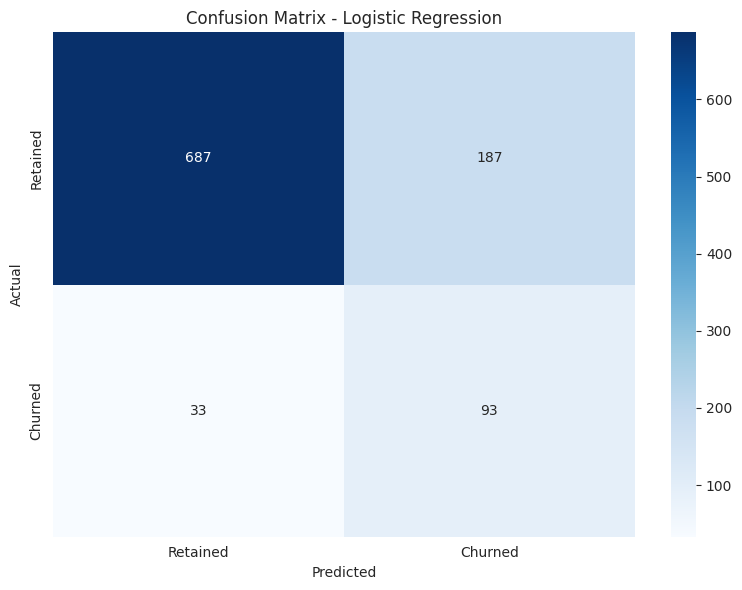

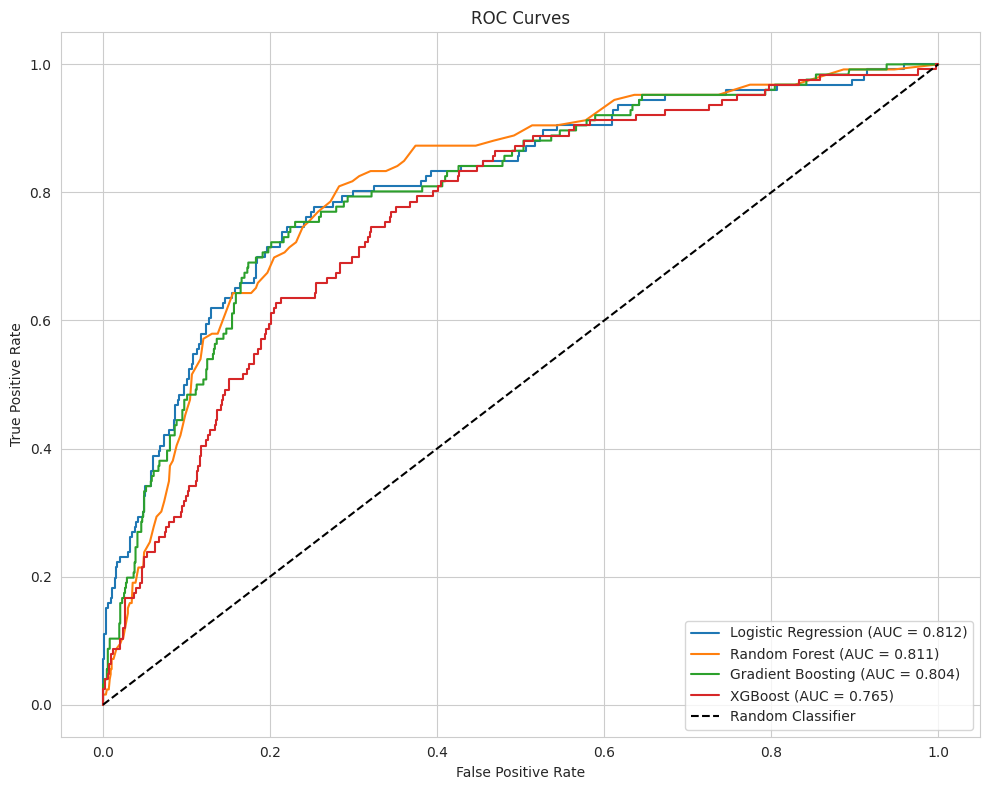

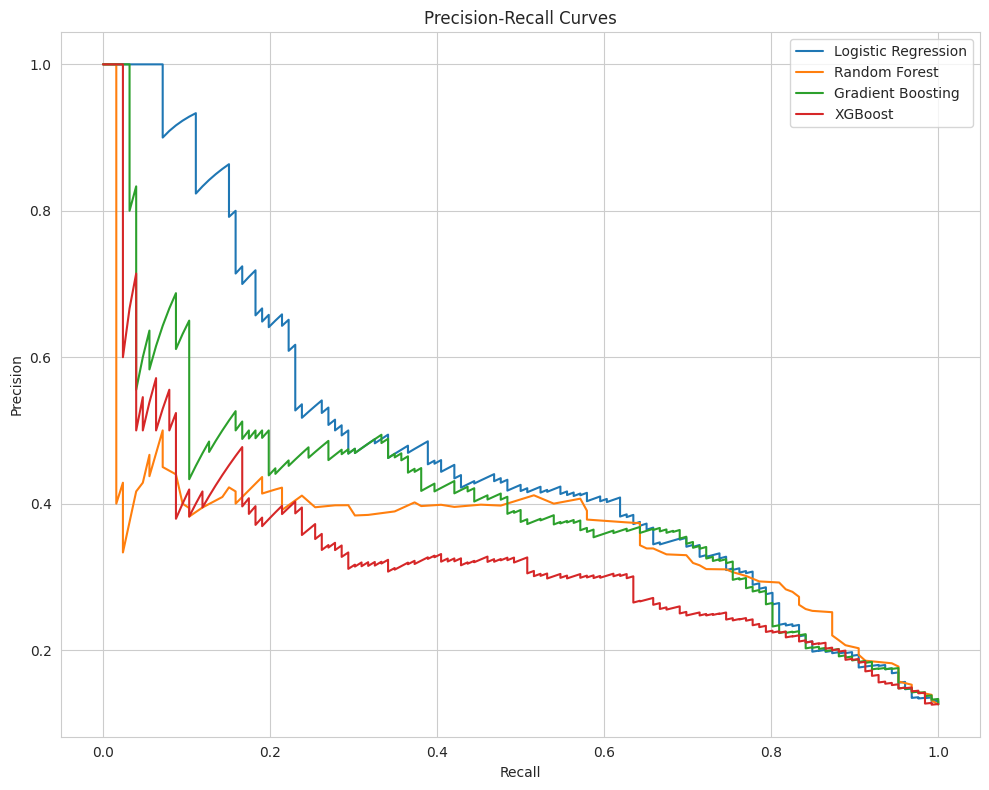

Best model and preprocessor saved!


In [9]:
# Step 6: Model Training and Evaluation
print("Training and evaluating models...")

def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names):
    print("=" * 50)
    print("MODEL TRAINING AND EVALUATION")
    print("=" * 50)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    }

    # Train and evaluate each model
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred_proba': y_pred_proba
        }

        # Print results
        print(f"{name} Results:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  ROC AUC:   {roc_auc:.4f}")

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"  CV ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

    # Find best model based on F1 score (balance of precision and recall)
    best_model_name = max(results, key=lambda x: results[x]['f1'])
    best_model = results[best_model_name]['model']

    print(f"\nBest model: {best_model_name} with F1 score: {results[best_model_name]['f1']:.4f}")

    # Detailed evaluation of best model
    print(f"\nDetailed classification report for {best_model_name}:")
    y_pred_best = best_model.predict(X_test)
    print(classification_report(y_test, y_pred_best))

    # Plot confusion matrix for best model
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Retained', 'Churned'],
                yticklabels=['Retained', 'Churned'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # Plot ROC curves for all models
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Plot precision-recall curves
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        plt.plot(recall_curve, precision_curve, label=name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return results, best_model

# Train and evaluate models
results, best_model = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names)

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Best model and preprocessor saved!")

Interpreting the model with SHAP...
MODEL INTERPRETATION WITH SHAP


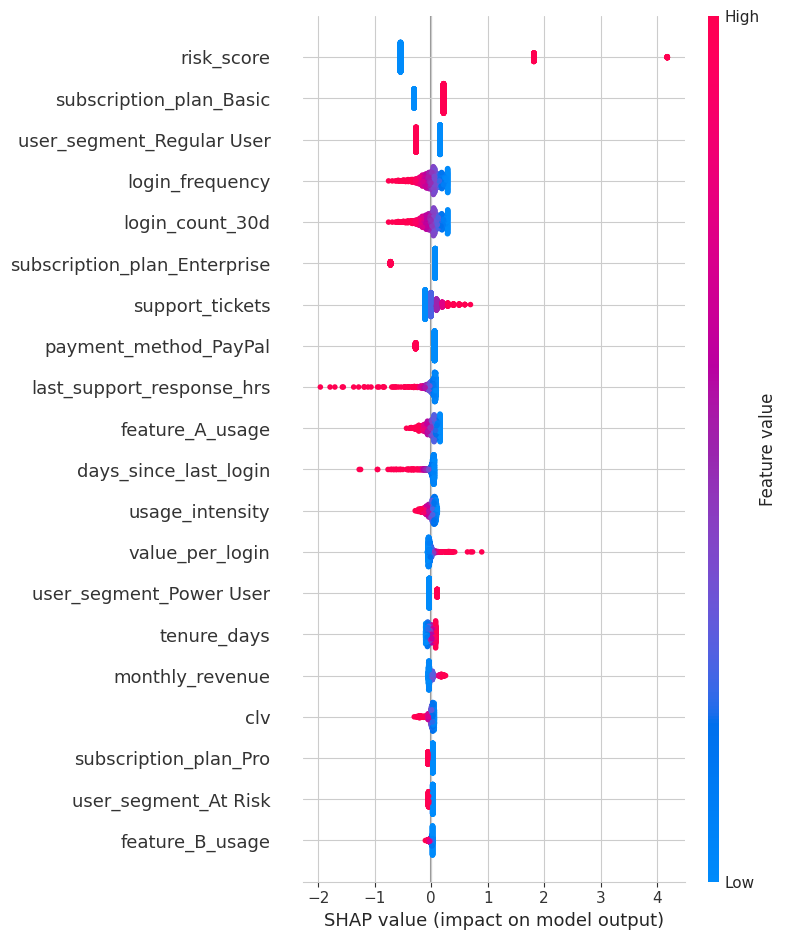

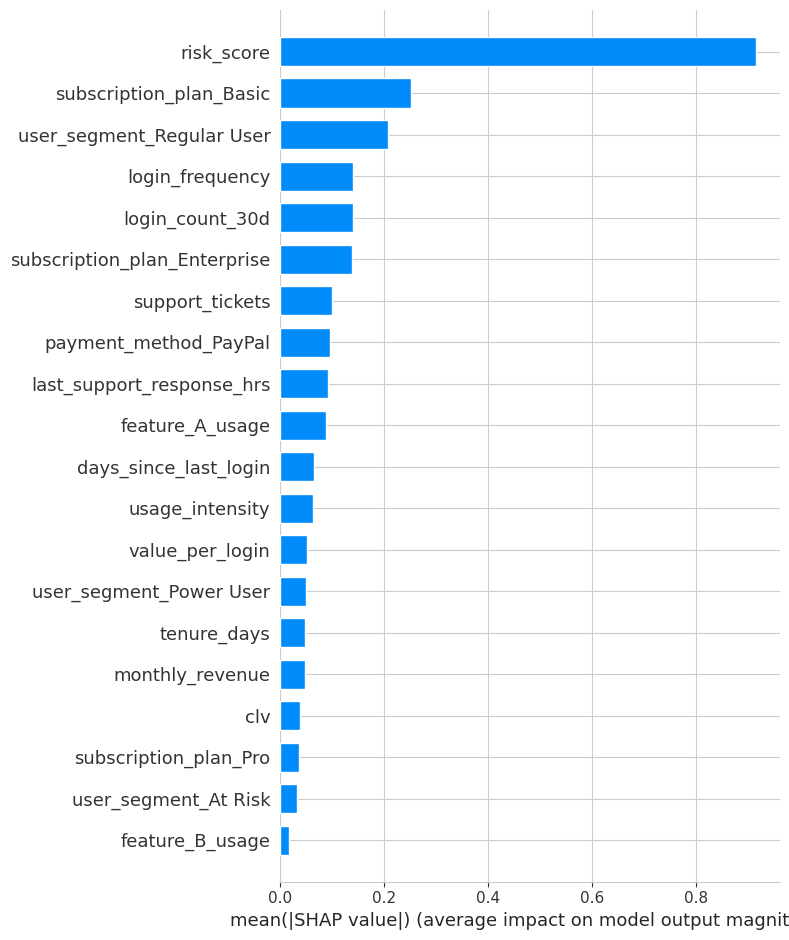

Top 10 most important features:
                         feature  importance
14                    risk_score    0.915670
15       subscription_plan_Basic    0.252041
23     user_segment_Regular User    0.208256
11               login_frequency    0.139683
2                login_count_30d    0.139683
16  subscription_plan_Enterprise    0.138233
5                support_tickets    0.100123
20         payment_method_PayPal    0.096360
6      last_support_response_hrs    0.092300
3                feature_A_usage    0.087640


In [11]:
# Step 7: Model Interpretation with SHAP
print("Interpreting the model with SHAP...")

def interpret_model(model, X_test, feature_names):
    print("=" * 50)
    print("MODEL INTERPRETATION WITH SHAP")
    print("=" * 50)

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test)

    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.show()

    # Bar plot of mean SHAP values
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()

    # Prepare feature importance data
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values).mean(0)
    }).sort_values('importance', ascending=False)

    print("Top 10 most important features:")
    print(feature_importance.head(10))

    return feature_importance, shap_values

# Interpret the best model
feature_importance, shap_values = interpret_model(best_model, X_test, feature_names)